In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os
from pathlib import Path
from tqdm import tqdm  
import skimage
from skimage.transform import resize
print(os.listdir("D:/chest_xray"))

['chest_xray', 'lung.ann', 'lung.csv', 'lung.forest', 'lung.h5', 'lung.kmean', 'lung.kne', 'lung.logit', 'lung.svm', 'lung.tree', 'lung.weights', 'lung2.h5', 'lung2.weights', 'test', 'total.jpg', 'train', 'val', '__MACOSX']


In [2]:
print(os.listdir("D:/chest_xray/train/"))

['NORMAL', 'PNEUMONIA']


In [3]:
data_dir = Path("D:/chest_xray/chest_xray")

train_dir = data_dir / 'train'

test_dir = data_dir / 'test'

In [4]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []


for img in normal_cases:
    train_data.append((str(img).split('\\')[-1],0))
    

for img in pneumonia_cases:
    train_data.append((str(img).split('\\')[-1], 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

train_data = train_data.sample(frac=1.).reset_index(drop=True)


train_data.to_csv('D:/chest_xray/lung.csv', encoding='utf-8')

train_data.head()

,image,label
0,NORMAL2-IM-0583-0001.jpeg,0
1,person1383_bacteria_3521.jpeg,1
2,person501_bacteria_2112.jpeg,1
3,IM-0612-0001-0001.jpeg,0
4,person48_bacteria_233.jpeg,1


1    3875
0    1341
Name: label, dtype: int64


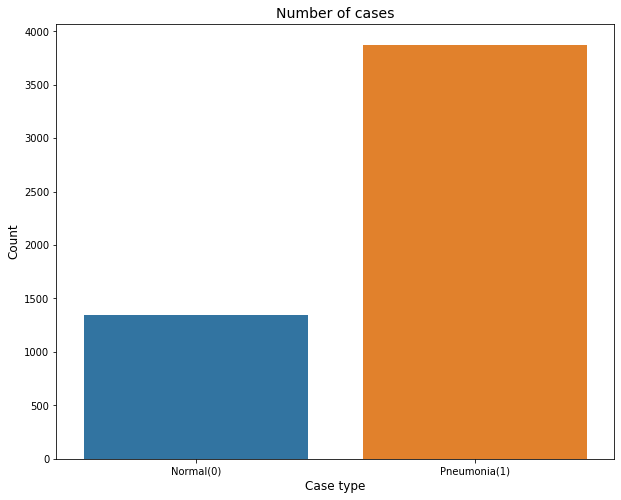

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



cases_count = train_data['label'].value_counts()
print(cases_count)


plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('D:/chest_xray/total.jpg', dpi=1000)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [6]:
TRAIN_DIR = "D:/chest_xray/train/"
TEST_DIR =  "D:/chest_xray/test/"

In [7]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [8]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
                
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [9]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            #i=0
            for file in tqdm(os.listdir(temp)):
                #if i>10:
                    #break
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                #i+=1
                
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [10]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 3875/3875 [09:22<00:00,  6.89it/s]


In [11]:
X_test , y_test = get_data(TEST_DIR)

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:45<00:00,  8.55it/s]


In [12]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [13]:
print(y_train.shape,'\n',y_test.shape)

(5216,) 
 (624,)


In [14]:
X_train=X_train.reshape(5216,67500).astype('float32')/255.0
X_test=X_test.reshape(624,67500).astype('float32')/255.0

로지스틱회귀분석

In [15]:
#예측률을 저장할 리스트
methods=[]
result_tr=[]
result_te=[]

In [17]:
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression(random_state=10)
logit.fit(X_train,y_train)

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=10, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
#모형 저장
import pickle
pickle.dump(logit, open("D:/chest_xray/lung.logit",'wb'))

In [ ]:
#모형 로딩
import pickle
model=pickle.load(open("D:/chest_xray/lung.logit",'rb'))

In [19]:
#예측정확도
score_tr='{:4.2f}'.format(logit.score(X_train,y_train)*100)
score_te='{:4.2f}'.format(logit.score(X_test,y_test)*100)
print('학습용:{}%'.format(score_tr))
print('검증용:{}%'.format(score_te))

학습용:87.63%
검증용:68.27%


In [20]:
#혼동행렬 출력
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

pred=logit.predict(X_test)
cm=confusion_matrix(y_test,pred)
df_cm=pd.DataFrame(cm,index=['Normal', 'Pneumonia'],columns=['Normal', 'Pneumonia'])
df_cm

,Normal,Pneumonia
Normal,36,198
Pneumonia,0,390


In [21]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [22]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_test,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_test,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_test,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_test,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_test, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

정확도:68.27%
재현율:100.00%
정밀도:66.33%
F1_score:79.75%
MCC:31.94%
FP_Rate:0.00%


In [23]:
methods.append('LOGIT')
result_tr.append(score_tr)
result_te.append(score_te)
print(methods)
print(result_tr)
print(result_te)

['LOGIT']
['87.63']
['68.27']


의사결정나무

In [ ]:
#의사결정나무
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(random_state=10,max_depth=15)
tree.fit(X_train,y_train)

In [25]:
#모형 저장
pickle.dump(tree, open("D:/chest_xray/lung.tree",'wb'))

In [ ]:
#모형 로딩
model=pickle.load(open("D:/chest_xray/lung.tree",'rb'))

In [26]:
#예측정확도
score_tr='{:4.2f}'.format(tree.score(X_train,y_train)*100)
score_te='{:4.2f}'.format(tree.score(X_test,y_test)*100)
print('학습용:{}%'.format(score_tr))
print('검증용:{}%'.format(score_te))

학습용:99.52%
검증용:72.44%


In [27]:
#혼동행렬 출력
pred=tree.predict(X_test)
cm=confusion_matrix(y_test,pred)
df_cm=pd.DataFrame(cm,index=['Normal', 'Pneumonia'],columns=['Normal', 'Pneumonia'])
df_cm

,Normal,Pneumonia
Normal,76,158
Pneumonia,14,376


In [28]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [29]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_test,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_test,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_test,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_test,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_test, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

정확도:72.44%
재현율:96.41%
정밀도:70.41%
F1_score:81.39%
MCC:39.81%
FP_Rate:0.04%


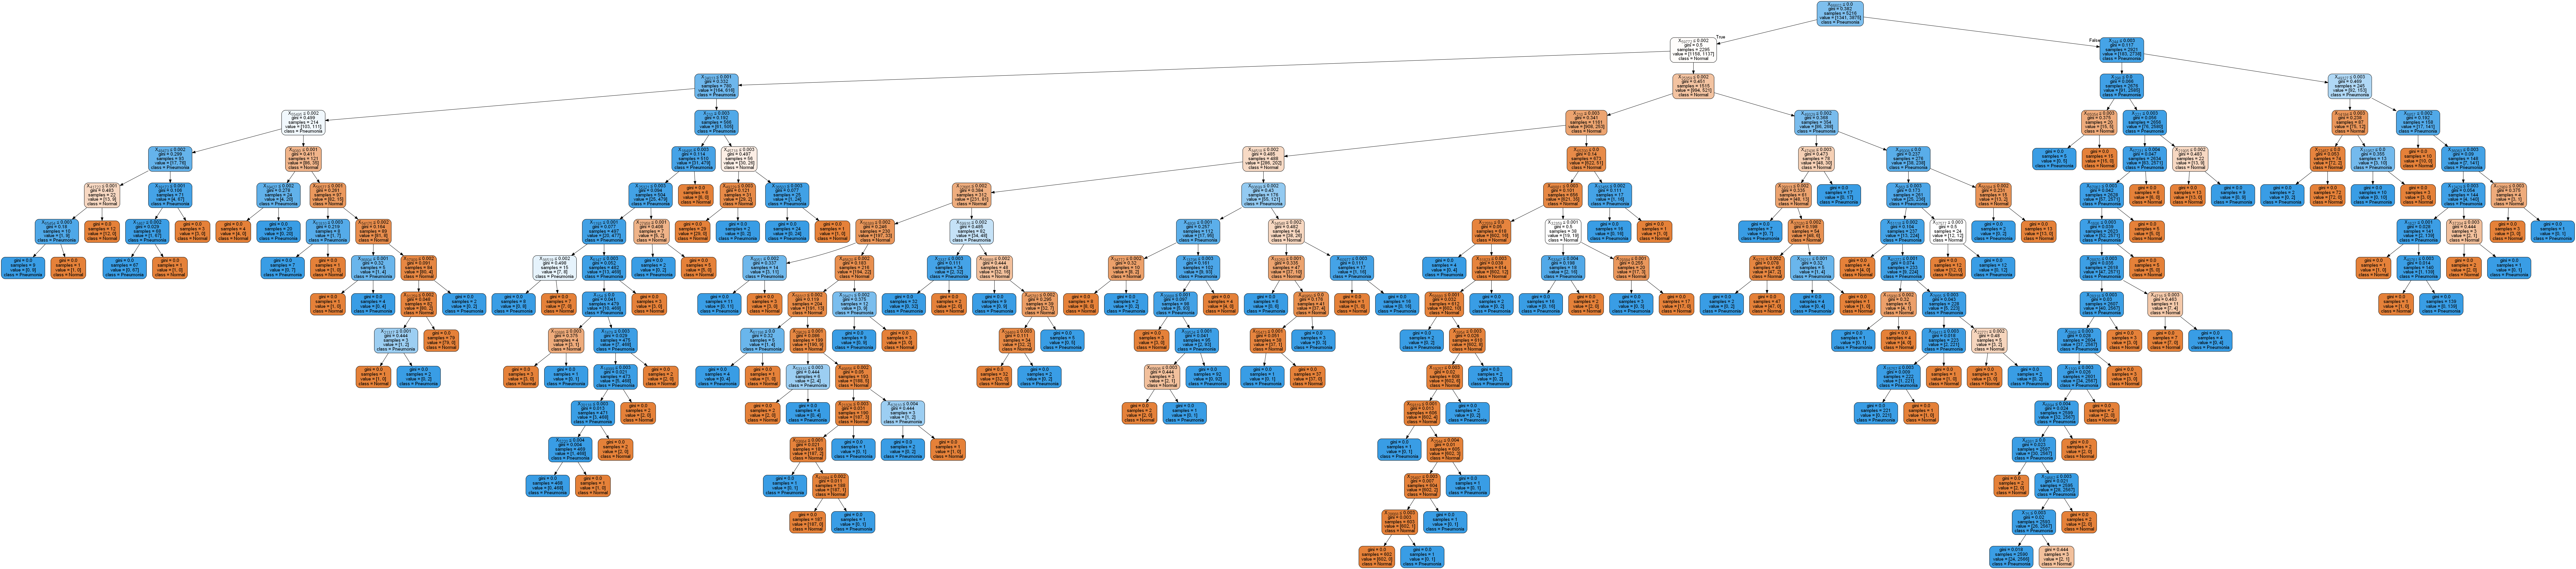

In [30]:
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from IPython.display import Image
                                                                             #트리 그래프
dot_data=export_graphviz(tree,out_file=None,
                         class_names=['Normal','Pneumonia'],filled=True,
                         rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_jpg('D:/chest_xray/tree.jpg')
Image(graph.create_png())

In [31]:
#리스트에 추가
methods.append('Tree')
result_tr.append(score_tr)
result_te.append(score_te)
print(methods)
print(result_tr)
print(result_te)

['LOGIT', 'Tree']
['87.63', '99.52']
['68.27', '72.44']


랜덤포레스트

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=70,random_state=10)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [33]:
#모형 저장
pickle.dump(forest, open("D:/chest_xray/lung.forest",'wb'))

In [ ]:
#모형 로딩
model=pickle.load(open("D:/chest_xray/lung.forest",'rb'))

In [34]:
#예측정확도
score_tr='{:4.2f}'.format(forest.score(X_train,y_train)*100)
score_te='{:4.2f}'.format(forest.score(X_test,y_test)*100)
print('학습용:{}%'.format(score_tr))
print('검증용:{}%'.format(score_te))

학습용:100.00%
검증용:76.92%


In [35]:
#혼동행렬 출력
pred=forest.predict(X_test)
cm=confusion_matrix(y_test,pred)
df_cm=pd.DataFrame(cm,index=['Normal', 'Pneumonia'],columns=['Normal', 'Pneumonia'])
df_cm

,Normal,Pneumonia
Normal,94,140
Pneumonia,4,386


In [36]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [37]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_test,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_test,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_test,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_test,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_test, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

정확도:76.92%
재현율:98.97%
정밀도:73.38%
F1_score:84.28%
MCC:52.09%
FP_Rate:0.01%


In [38]:
#리스트에 추가
methods.append('RF')
result_tr.append(score_tr)
result_te.append(score_te)
print(methods)
print(result_tr)
print(result_te)

['LOGIT', 'Tree', 'RF']
['87.63', '99.52', '100.00']
['68.27', '72.44', '76.92']


SVM

최적의 c: 1000
최적의 gamma: 0.01
최적의 정확도: 0.7467948717948718


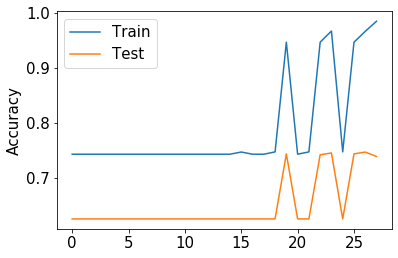

In [39]:
from sklearn.svm import SVC
train_rate=[]
test_rate=[]
c_values=[0.001,0.01,0.1,1,10,100,1000]
g_values=[0.0001,0.001,0.01,0.1]
for n in c_values:
    for g in g_values:
        model=SVC(C=n,gamma=g, random_state=10)
        model.fit(X_train,y_train)
        train_rate.append(
        [n,g,model.score(X_train,y_train)])
        test_rate.append(
        [n,g,model.score(X_test,y_test)])
        
train_arr=np.array(train_rate)
test_arr=np.array(test_rate)
max_rate=np.max(test_arr[:,2])
idx=np.where(test_arr[:,2]==max_rate)[0][0]
print('최적의 c:',test_rate[idx][0])
print('최적의 gamma:',test_rate[idx][1])
print('최적의 정확도:', test_rate[idx][2])

plt.rcParams['font.size']=15
plt.plot(range(len(train_rate)),train_arr[:,2],label='Train')
plt.plot(range(len(test_rate)),test_arr[:,2],label='Test')
plt.ylabel('Accuracy')
plt.savefig('D:/chest_xray/svc.jpg', dpi=700)
plt.legend()
plt.show()

In [41]:
#모형 저장
pickle.dump(svm, open("D:/chest_xray/lung.svm",'wb'))

In [ ]:
#모형 로딩
model=pickle.load(open("D:/chest_xray/lung.svm",'rb'))

In [40]:
#최적의 파라미터를 적용한 SVM 모형
svm=SVC(C=1000, gamma=0.01, random_state=10)
svm.fit(X_train,y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=10, shrinking=True, tol=0.001,
    verbose=False)

In [42]:
score_tr='{:4.2f}'.format(svm.score(X_train,y_train)*100)
score_te='{:4.2f}'.format(svm.score(X_test,y_test)*100)
print('학습용:{}%'.format(score_tr))
print('검증용:{}%'.format(score_te))

학습용:96.68%
검증용:74.68%


In [43]:
#혼동행렬 출력
pred=svm.predict(X_test)
cm=confusion_matrix(y_test,pred)
df_cm=pd.DataFrame(cm,index=['Normal', 'Pneumonia'],columns=['Normal', 'Pneumonia'])
df_cm

,Normal,Pneumonia
Normal,81,153
Pneumonia,5,385


In [44]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [45]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_test,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_test,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_test,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_test,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_test, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

정확도:74.68%
재현율:98.72%
정밀도:71.56%
F1_score:82.97%
MCC:46.81%
FP_Rate:0.01%


In [46]:
#리스트에 추가
methods.append('SVM')
result_tr.append(score_tr)
result_te.append(score_te)
print(methods)
print(result_tr)
print(result_te)

['LOGIT', 'Tree', 'RF', 'SVM']
['87.63', '99.52', '100.00', '96.68']
['68.27', '72.44', '76.92', '74.68']


인공신경망

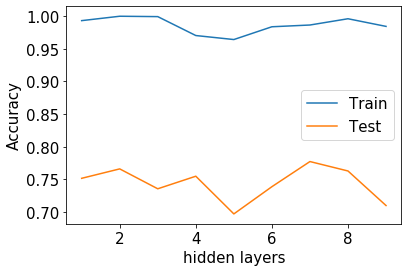

최적의 k: 7
최적의 정확도: 0.7772435897435898
300 100


In [47]:
#최적의 은닉노드 갯수를 구하는 실험
from sklearn.neural_network import MLPClassifier
train_rate=[]
test_rate=[]
for i in range(100,301,100):
    for j in range(100,301,100):
        model=MLPClassifier(random_state=10,
                           hidden_layer_sizes=[i,j],max_iter=1000)
        model.fit(X_train,y_train)
        train_rate.append(model.score(X_train,y_train))
        test_rate.append(model.score(X_test,y_test))
        
plt.rcParams['font.size']=15
plt.plot(range(1,10),train_rate,label='Train')
plt.plot(range(1,10),test_rate,label='Test')
plt.ylabel('Accuracy')
plt.xlabel('hidden layers')
plt.savefig('D:/chest_xray/ann.jpg', dpi=700)
plt.legend()
plt.show()

max_rate=max(test_rate)#최대값
idx=np.where(test_rate == max_rate)[0][0] #최대값의 위치
print('최적의 k:',idx+1)
print('최적의 정확도:',max_rate)
cnt=0
for i in range(100,301,100):
    for j in range(100,301,100):
        if cnt==idx:
            print(i,j) #값을 출력하고
            break
        cnt+=1 #카운트 증가 처리

In [49]:
#모형 저장
pickle.dump(ann, open("D:/chest_xray/lung.ann",'wb'))

In [ ]:
#모형 로딩
model=pickle.load(open("D:/chest_xray/lung.ann",'rb'))

In [48]:
#실험을 통해 얻은 최적의 노드 갯수를 적용한 인공신경망 모형
ann=MLPClassifier(hidden_layer_sizes=[300,100],random_state=100)
ann.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[300, 100], learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=100, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [50]:
score_tr='{:4.2f}'.format(ann.score(X_train,y_train)*100)
score_te='{:4.2f}'.format(ann.score(X_test,y_test)*100)
print('학습용:{}%'.format(score_tr))
print('검증용:{}%'.format(score_te))

학습용:98.62%
검증용:77.72%


In [51]:
#혼동행렬 출력
pred=ann.predict(X_test)
cm=confusion_matrix(y_test,pred)
df_cm=pd.DataFrame(cm,index=['Normal', 'Pneumonia'],columns=['Normal', 'Pneumonia'])
df_cm

,Normal,Pneumonia
Normal,102,132
Pneumonia,7,383


In [52]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [53]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_test,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_test,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_test,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_test,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_test, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

정확도:77.72%
재현율:98.21%
정밀도:74.37%
F1_score:84.64%
MCC:53.29%
FP_Rate:0.02%


In [54]:
#리스트에 추가
methods.append('ANN')
result_tr.append(score_tr)
result_te.append(score_te)
print(methods)
print(result_tr)
print(result_te)

['LOGIT', 'Tree', 'RF', 'SVM', 'ANN']
['87.63', '99.52', '100.00', '96.68', '98.62']
['68.27', '72.44', '76.92', '74.68', '77.72']


KNN

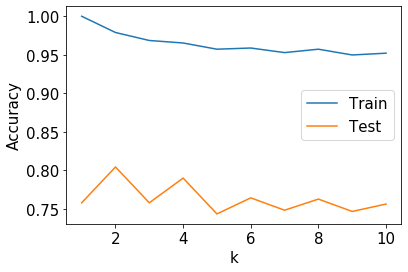

최적의 k: 2
최적의 정확도: 0.8044871794871795


In [55]:
#최적의 k를 도출하기 위한 코드
from sklearn.neighbors import KNeighborsClassifier
train_rate=[]
test_rate=[]
neighbors=range(1,11)
for n in neighbors:
    knn=KNeighborsClassifier(n_neighbors=n) #n_neighbors 이웃의 수
    knn.fit(X_train,y_train) #이미지 100장만 학습
    #정확도를 저장
    train_rate.append(knn.score(X_train,y_train))
    test_rate.append(knn.score(X_test,y_test))
    
plt.rcParams['font.size']=15 #그래프의 폰트 사이즈
plt.plot(neighbors,train_rate,label='Train') #학습용 정확도
plt.plot(neighbors,test_rate,label='Test') #검증용 정확도
plt.ylabel('Accuracy') #y축의 라벨
plt.xlabel('k') #x축의 라벨
plt.savefig('D:/chest_xray/knn.jpg', dpi=700)
plt.legend() #범례 표시
plt.show()

max_rate=max(test_rate) #최대값
idx=np.argmax(test_rate) #최대값이 몇번째 인덱스에 있는지 계산
print('최적의 k:',idx+1)
print('최적의 정확도:',max_rate)

In [57]:
#모형 저장
pickle.dump(knn, open("D:/chest_xray/lung.knn",'wb'))

In [ ]:
#모형 로딩
model=pickle.load(open("D:/chest_xray/lung.knn",'rb'))

In [56]:
#k-모형
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [58]:
#모형평가
score_tr='{:4.2f}'.format(knn.score(X_train,y_train)*100)
score_te='{:4.2f}'.format(knn.score(X_test,y_test)*100)
print('학습용:{}%'.format(score_tr))
print('검증용:{}%'.format(score_te))

학습용:97.89%
검증용:80.45%


In [59]:
#혼동행렬 출력
pred=knn.predict(X_test)
cm=confusion_matrix(y_test,pred)
df_cm=pd.DataFrame(cm,index=['Normal', 'Pneumonia'],columns=['Normal', 'Pneumonia'])
df_cm

,Normal,Pneumonia
Normal,125,109
Pneumonia,13,377


In [60]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [61]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_test,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_test,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_test,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_test,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_test, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

정확도:80.45%
재현율:96.67%
정밀도:77.57%
F1_score:86.07%
MCC:58.42%
FP_Rate:0.03%


In [62]:
#리스트에 추가
methods.append('KNN')
result_tr.append(score_tr)
result_te.append(score_te)
print(methods)
print(result_tr)
print(result_te)

['LOGIT', 'Tree', 'RF', 'SVM', 'ANN', 'KNN']
['87.63', '99.52', '100.00', '96.68', '98.62', '97.89']
['68.27', '72.44', '76.92', '74.68', '77.72', '80.45']


k- means cluster

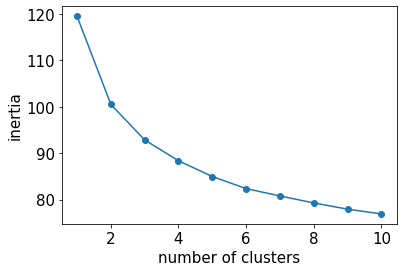

In [63]:
from sklearn.cluster import KMeans

clusters = range(1,11)
inertias=[]

for n in clusters:
    k_cluster=KMeans(n_clusters=n, random_state=10)
    k_cluster.fit(X_train)
    inertias.append(k_cluster.inertia_)

plt.rcParams['font.size']=15
plt.plot(clusters,inertias,'-o')
plt.ylabel('inertia')
plt.xlabel('number of clusters')
plt.savefig('D:/chest_xray/K_cluster.jpg', dpi=700)
plt.show()

In [65]:
#모형 저장
pickle.dump(k_cluster, open("D:/chest_xray/lung.kmean",'wb'))

In [ ]:
#모형 로딩
model=pickle.load(open("D:/chest_xray/lung.kmean",'rb'))

In [64]:
k_cluster= KMeans(n_clusters=2,random_state=10)
k_cluster.fit(X_train)
print(k_cluster)
pred_tr=k_cluster.predict(X_train,y_train)
#print(pred1)
pred_te=k_cluster.predict(X_test,y_test)
#print(pred2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)


In [66]:
#실루엣포인트: 군집화 지수
from sklearn.metrics import silhouette_score
score_tr='{:4.2f}'.format(silhouette_score(X_train, pred_tr)*100)
score_te='{:4.2f}'.format(silhouette_score(X_test, pred_te)*100)
print('학습용:{}%'.format(score_tr))
print('검증용:{}%'.format(score_te))

학습용:13.57%
검증용:14.01%


In [67]:
#혼동행렬 출력
pred=k_cluster.predict(X_test)
cm=confusion_matrix(y_test,pred)
df_cm=pd.DataFrame(cm,index=['Normal', 'Pneumonia'],columns=['Normal', 'Pneumonia'])
df_cm

,Normal,Pneumonia
Normal,109,125
Pneumonia,237,153


In [68]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [69]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_test,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_test,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_test,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_test,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_test, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

정확도:41.99%
재현율:39.23%
정밀도:55.04%
F1_score:45.81%
MCC:-13.82%
FP_Rate:0.61%


In [ ]:
# #모형평가
# score_tr=k_cluster.score(X_train)
# score_te=k_cluster.score(X_test)
# print(score_tr)
# print(score_te)

In [70]:
#리스트에 추가
methods.append('K-Means')
result_tr.append(score_tr)
result_te.append(score_te)
print(methods)
print(result_tr)
print(result_te)

['LOGIT', 'Tree', 'RF', 'SVM', 'ANN', 'KNN', 'K-Means']
['87.63', '99.52', '100.00', '96.68', '98.62', '97.89', '13.57']
['68.27', '72.44', '76.92', '74.68', '77.72', '80.45', '14.01']


인공신경망(keras-CNN(합성곱))

In [71]:
X_train=X_train.reshape(5216,150,150,3).astype('float32')/255.0
X_test=X_test.reshape(624,150,150,3).astype('float32')/255.0

In [72]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [73]:
print(y_train.shape,'\n',y_test.shape)

(5216, 2) 
 (624, 2)


In [74]:
#시그모이드
from keras import optimizers
from keras import layers 
from keras import models

model= models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
          
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(256,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
          
model.add(layers.Conv2D(512,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 256)      

In [75]:
history = model.fit(X_train,y_train, validation_split=0.2,epochs=20,batch_size=16) #20번

Train on 4172 samples, validate on 1044 samples
Epoch 1/20
3360/4172 [=======================>......] - ETA: 4:32 - loss: 0.6931 - acc: 0.593 - ETA: 2:54 - loss: 0.6924 - acc: 0.765 - ETA: 2:21 - loss: 0.6918 - acc: 0.739 - ETA: 2:04 - loss: 0.6915 - acc: 0.710 - ETA: 1:54 - loss: 0.6905 - acc: 0.706 - ETA: 1:47 - loss: 0.6877 - acc: 0.724 - ETA: 1:42 - loss: 0.6896 - acc: 0.683 - ETA: 1:38 - loss: 0.6879 - acc: 0.683 - ETA: 1:35 - loss: 0.6887 - acc: 0.663 - ETA: 1:33 - loss: 0.6917 - acc: 0.628 - ETA: 1:30 - loss: 0.6898 - acc: 0.644 - ETA: 1:29 - loss: 0.6880 - acc: 0.653 - ETA: 1:27 - loss: 0.6836 - acc: 0.675 - ETA: 1:26 - loss: 0.6812 - acc: 0.676 - ETA: 1:24 - loss: 0.6787 - acc: 0.677 - ETA: 1:23 - loss: 0.6731 - acc: 0.685 - ETA: 1:22 - loss: 0.6728 - acc: 0.682 - ETA: 1:21 - loss: 0.6740 - acc: 0.675 - ETA: 1:20 - loss: 0.6751 - acc: 0.669 - ETA: 1:20 - loss: 0.6758 - acc: 0.664 - ETA: 1:19 - loss: 0.6706 - acc: 0.674 - ETA: 1:18 - loss: 0.6671 - acc: 0.677 - ETA: 1:17 - loss

3392/4172 [=======================>......] - ETA: 1:14 - loss: 0.4773 - acc: 0.875 - ETA: 1:14 - loss: 0.4363 - acc: 0.906 - ETA: 1:15 - loss: 0.4553 - acc: 0.875 - ETA: 1:14 - loss: 0.5140 - acc: 0.812 - ETA: 1:14 - loss: 0.5497 - acc: 0.775 - ETA: 1:13 - loss: 0.5539 - acc: 0.770 - ETA: 1:13 - loss: 0.5889 - acc: 0.732 - ETA: 1:13 - loss: 0.5931 - acc: 0.726 - ETA: 1:13 - loss: 0.6018 - acc: 0.715 - ETA: 1:12 - loss: 0.6001 - acc: 0.718 - ETA: 1:12 - loss: 0.6061 - acc: 0.710 - ETA: 1:12 - loss: 0.6077 - acc: 0.708 - ETA: 1:12 - loss: 0.6220 - acc: 0.687 - ETA: 1:11 - loss: 0.6216 - acc: 0.687 - ETA: 1:11 - loss: 0.6217 - acc: 0.687 - ETA: 1:11 - loss: 0.6344 - acc: 0.668 - ETA: 1:11 - loss: 0.6322 - acc: 0.672 - ETA: 1:10 - loss: 0.6300 - acc: 0.677 - ETA: 1:10 - loss: 0.6252 - acc: 0.684 - ETA: 1:10 - loss: 0.6245 - acc: 0.684 - ETA: 1:09 - loss: 0.6219 - acc: 0.687 - ETA: 1:09 - loss: 0.6241 - acc: 0.684 - ETA: 1:09 - loss: 0.6239 - acc: 0.684 - ETA: 1:09 - loss: 0.6261 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6289 - acc: 0.68 - ETA: 13s - loss: 0.6286 - acc: 0.68 - ETA: 13s - loss: 0.6285 - acc: 0.68 - ETA: 13s - loss: 0.6283 - acc: 0.68 - ETA: 12s - loss: 0.6281 - acc: 0.68 - ETA: 12s - loss: 0.6286 - acc: 0.68 - ETA: 12s - loss: 0.6288 - acc: 0.68 - ETA: 11s - loss: 0.6292 - acc: 0.68 - ETA: 11s - loss: 0.6291 - acc: 0.68 - ETA: 11s - loss: 0.6300 - acc: 0.67 - ETA: 11s - loss: 0.6298 - acc: 0.67 - ETA: 10s - loss: 0.6300 - acc: 0.67 - ETA: 10s - loss: 0.6294 - acc: 0.68 - ETA: 10s - loss: 0.6297 - acc: 0.68 - ETA: 9s - loss: 0.6301 - acc: 0.6798 - ETA: 9s - loss: 0.6302 - acc: 0.679 - ETA: 9s - loss: 0.6303 - acc: 0.679 - ETA: 8s - loss: 0.6299 - acc: 0.680 - ETA: 8s - loss: 0.6299 - acc: 0.680 - ETA: 8s - loss: 0.6304 - acc: 0.679 - ETA: 8s - loss: 0.6309 - acc: 0.678 - ETA: 7s - loss: 0.6311 - acc: 0.678 - ETA: 7s - loss: 0.6312 - acc: 0.677 - ETA: 7s - loss: 0.6311 - acc: 0.678 - ETA: 6s - loss: 0.6310 - acc: 0.678 - ETA:

3392/4172 [=======================>......] - ETA: 1:13 - loss: 0.6562 - acc: 0.625 - ETA: 1:15 - loss: 0.6062 - acc: 0.718 - ETA: 1:14 - loss: 0.6392 - acc: 0.666 - ETA: 1:14 - loss: 0.6250 - acc: 0.687 - ETA: 1:14 - loss: 0.5843 - acc: 0.750 - ETA: 1:14 - loss: 0.5721 - acc: 0.760 - ETA: 1:14 - loss: 0.5717 - acc: 0.758 - ETA: 1:13 - loss: 0.5864 - acc: 0.742 - ETA: 1:13 - loss: 0.5906 - acc: 0.736 - ETA: 1:13 - loss: 0.5899 - acc: 0.737 - ETA: 1:12 - loss: 0.5935 - acc: 0.733 - ETA: 1:12 - loss: 0.5947 - acc: 0.729 - ETA: 1:12 - loss: 0.6132 - acc: 0.706 - ETA: 1:12 - loss: 0.6199 - acc: 0.696 - ETA: 1:11 - loss: 0.6283 - acc: 0.683 - ETA: 1:11 - loss: 0.6323 - acc: 0.675 - ETA: 1:11 - loss: 0.6321 - acc: 0.676 - ETA: 1:10 - loss: 0.6379 - acc: 0.666 - ETA: 1:10 - loss: 0.6407 - acc: 0.661 - ETA: 1:10 - loss: 0.6433 - acc: 0.656 - ETA: 1:10 - loss: 0.6454 - acc: 0.651 - ETA: 1:09 - loss: 0.6441 - acc: 0.656 - ETA: 1:09 - loss: 0.6424 - acc: 0.660 - ETA: 1:09 - loss: 0.6447 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6295 - acc: 0.68 - ETA: 13s - loss: 0.6296 - acc: 0.67 - ETA: 13s - loss: 0.6295 - acc: 0.68 - ETA: 13s - loss: 0.6294 - acc: 0.68 - ETA: 12s - loss: 0.6293 - acc: 0.68 - ETA: 12s - loss: 0.6299 - acc: 0.67 - ETA: 12s - loss: 0.6297 - acc: 0.67 - ETA: 11s - loss: 0.6295 - acc: 0.68 - ETA: 11s - loss: 0.6297 - acc: 0.67 - ETA: 11s - loss: 0.6296 - acc: 0.67 - ETA: 11s - loss: 0.6296 - acc: 0.67 - ETA: 10s - loss: 0.6296 - acc: 0.68 - ETA: 10s - loss: 0.6302 - acc: 0.67 - ETA: 10s - loss: 0.6297 - acc: 0.68 - ETA: 9s - loss: 0.6297 - acc: 0.6801 - ETA: 9s - loss: 0.6298 - acc: 0.679 - ETA: 9s - loss: 0.6295 - acc: 0.680 - ETA: 9s - loss: 0.6290 - acc: 0.681 - ETA: 8s - loss: 0.6287 - acc: 0.681 - ETA: 8s - loss: 0.6287 - acc: 0.681 - ETA: 8s - loss: 0.6284 - acc: 0.681 - ETA: 7s - loss: 0.6284 - acc: 0.681 - ETA: 7s - loss: 0.6281 - acc: 0.681 - ETA: 7s - loss: 0.6283 - acc: 0.681 - ETA: 6s - loss: 0.6282 - acc: 0.681 - ETA:

3392/4172 [=======================>......] - ETA: 1:16 - loss: 0.5798 - acc: 0.750 - ETA: 1:14 - loss: 0.6724 - acc: 0.625 - ETA: 1:15 - loss: 0.6723 - acc: 0.625 - ETA: 1:14 - loss: 0.6505 - acc: 0.656 - ETA: 1:14 - loss: 0.6703 - acc: 0.625 - ETA: 1:14 - loss: 0.6691 - acc: 0.625 - ETA: 1:14 - loss: 0.6783 - acc: 0.607 - ETA: 1:14 - loss: 0.6733 - acc: 0.617 - ETA: 1:13 - loss: 0.6720 - acc: 0.618 - ETA: 1:13 - loss: 0.6644 - acc: 0.631 - ETA: 1:12 - loss: 0.6606 - acc: 0.636 - ETA: 1:12 - loss: 0.6481 - acc: 0.656 - ETA: 1:12 - loss: 0.6424 - acc: 0.663 - ETA: 1:12 - loss: 0.6374 - acc: 0.669 - ETA: 1:11 - loss: 0.6326 - acc: 0.675 - ETA: 1:11 - loss: 0.6364 - acc: 0.671 - ETA: 1:11 - loss: 0.6357 - acc: 0.672 - ETA: 1:10 - loss: 0.6459 - acc: 0.659 - ETA: 1:10 - loss: 0.6432 - acc: 0.664 - ETA: 1:10 - loss: 0.6426 - acc: 0.665 - ETA: 1:10 - loss: 0.6391 - acc: 0.669 - ETA: 1:09 - loss: 0.6429 - acc: 0.664 - ETA: 1:09 - loss: 0.6419 - acc: 0.665 - ETA: 1:09 - loss: 0.6375 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6330 - acc: 0.67 - ETA: 13s - loss: 0.6332 - acc: 0.67 - ETA: 13s - loss: 0.6328 - acc: 0.67 - ETA: 13s - loss: 0.6325 - acc: 0.67 - ETA: 12s - loss: 0.6316 - acc: 0.67 - ETA: 12s - loss: 0.6314 - acc: 0.67 - ETA: 12s - loss: 0.6311 - acc: 0.67 - ETA: 11s - loss: 0.6307 - acc: 0.67 - ETA: 11s - loss: 0.6307 - acc: 0.67 - ETA: 11s - loss: 0.6307 - acc: 0.67 - ETA: 11s - loss: 0.6304 - acc: 0.67 - ETA: 10s - loss: 0.6310 - acc: 0.67 - ETA: 10s - loss: 0.6312 - acc: 0.67 - ETA: 10s - loss: 0.6310 - acc: 0.67 - ETA: 9s - loss: 0.6312 - acc: 0.6784 - ETA: 9s - loss: 0.6316 - acc: 0.677 - ETA: 9s - loss: 0.6315 - acc: 0.677 - ETA: 8s - loss: 0.6311 - acc: 0.678 - ETA: 8s - loss: 0.6313 - acc: 0.678 - ETA: 8s - loss: 0.6314 - acc: 0.678 - ETA: 8s - loss: 0.6315 - acc: 0.677 - ETA: 7s - loss: 0.6313 - acc: 0.678 - ETA: 7s - loss: 0.6310 - acc: 0.678 - ETA: 7s - loss: 0.6307 - acc: 0.678 - ETA: 6s - loss: 0.6309 - acc: 0.678 - ETA:

3392/4172 [=======================>......] - ETA: 1:15 - loss: 0.7013 - acc: 0.562 - ETA: 1:14 - loss: 0.7023 - acc: 0.562 - ETA: 1:15 - loss: 0.6881 - acc: 0.583 - ETA: 1:14 - loss: 0.6994 - acc: 0.562 - ETA: 1:14 - loss: 0.6772 - acc: 0.600 - ETA: 1:13 - loss: 0.6758 - acc: 0.604 - ETA: 1:14 - loss: 0.6798 - acc: 0.598 - ETA: 1:13 - loss: 0.6735 - acc: 0.609 - ETA: 1:13 - loss: 0.6692 - acc: 0.618 - ETA: 1:12 - loss: 0.6729 - acc: 0.612 - ETA: 1:12 - loss: 0.6630 - acc: 0.630 - ETA: 1:12 - loss: 0.6662 - acc: 0.625 - ETA: 1:12 - loss: 0.6606 - acc: 0.634 - ETA: 1:11 - loss: 0.6547 - acc: 0.642 - ETA: 1:11 - loss: 0.6442 - acc: 0.658 - ETA: 1:11 - loss: 0.6555 - acc: 0.644 - ETA: 1:11 - loss: 0.6481 - acc: 0.654 - ETA: 1:10 - loss: 0.6513 - acc: 0.649 - ETA: 1:10 - loss: 0.6545 - acc: 0.644 - ETA: 1:10 - loss: 0.6634 - acc: 0.631 - ETA: 1:09 - loss: 0.6616 - acc: 0.633 - ETA: 1:09 - loss: 0.6620 - acc: 0.633 - ETA: 1:09 - loss: 0.6588 - acc: 0.638 - ETA: 1:09 - loss: 0.6559 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6357 - acc: 0.67 - ETA: 13s - loss: 0.6357 - acc: 0.67 - ETA: 13s - loss: 0.6351 - acc: 0.67 - ETA: 13s - loss: 0.6353 - acc: 0.67 - ETA: 12s - loss: 0.6350 - acc: 0.67 - ETA: 12s - loss: 0.6347 - acc: 0.67 - ETA: 12s - loss: 0.6355 - acc: 0.67 - ETA: 11s - loss: 0.6350 - acc: 0.67 - ETA: 11s - loss: 0.6351 - acc: 0.67 - ETA: 11s - loss: 0.6344 - acc: 0.67 - ETA: 11s - loss: 0.6349 - acc: 0.67 - ETA: 10s - loss: 0.6355 - acc: 0.67 - ETA: 10s - loss: 0.6350 - acc: 0.67 - ETA: 10s - loss: 0.6351 - acc: 0.67 - ETA: 9s - loss: 0.6353 - acc: 0.6729 - ETA: 9s - loss: 0.6349 - acc: 0.673 - ETA: 9s - loss: 0.6342 - acc: 0.674 - ETA: 9s - loss: 0.6348 - acc: 0.673 - ETA: 8s - loss: 0.6346 - acc: 0.674 - ETA: 8s - loss: 0.6347 - acc: 0.673 - ETA: 8s - loss: 0.6350 - acc: 0.673 - ETA: 7s - loss: 0.6352 - acc: 0.673 - ETA: 7s - loss: 0.6353 - acc: 0.672 - ETA: 7s - loss: 0.6349 - acc: 0.673 - ETA: 6s - loss: 0.6345 - acc: 0.674 - ETA:

3392/4172 [=======================>......] - ETA: 1:13 - loss: 0.6223 - acc: 0.687 - ETA: 1:15 - loss: 0.6274 - acc: 0.687 - ETA: 1:14 - loss: 0.6676 - acc: 0.625 - ETA: 1:14 - loss: 0.6401 - acc: 0.671 - ETA: 1:14 - loss: 0.6196 - acc: 0.700 - ETA: 1:14 - loss: 0.6336 - acc: 0.677 - ETA: 1:14 - loss: 0.6604 - acc: 0.633 - ETA: 1:13 - loss: 0.6475 - acc: 0.656 - ETA: 1:13 - loss: 0.6413 - acc: 0.666 - ETA: 1:13 - loss: 0.6393 - acc: 0.668 - ETA: 1:12 - loss: 0.6421 - acc: 0.664 - ETA: 1:12 - loss: 0.6370 - acc: 0.671 - ETA: 1:12 - loss: 0.6292 - acc: 0.682 - ETA: 1:12 - loss: 0.6257 - acc: 0.687 - ETA: 1:11 - loss: 0.6318 - acc: 0.679 - ETA: 1:11 - loss: 0.6304 - acc: 0.679 - ETA: 1:11 - loss: 0.6269 - acc: 0.683 - ETA: 1:10 - loss: 0.6236 - acc: 0.687 - ETA: 1:10 - loss: 0.6267 - acc: 0.684 - ETA: 1:10 - loss: 0.6234 - acc: 0.687 - ETA: 1:10 - loss: 0.6259 - acc: 0.684 - ETA: 1:09 - loss: 0.6306 - acc: 0.679 - ETA: 1:09 - loss: 0.6342 - acc: 0.673 - ETA: 1:09 - loss: 0.6335 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6312 - acc: 0.67 - ETA: 13s - loss: 0.6307 - acc: 0.67 - ETA: 13s - loss: 0.6324 - acc: 0.67 - ETA: 13s - loss: 0.6321 - acc: 0.67 - ETA: 12s - loss: 0.6323 - acc: 0.67 - ETA: 12s - loss: 0.6324 - acc: 0.67 - ETA: 12s - loss: 0.6325 - acc: 0.67 - ETA: 11s - loss: 0.6317 - acc: 0.67 - ETA: 11s - loss: 0.6317 - acc: 0.67 - ETA: 11s - loss: 0.6310 - acc: 0.67 - ETA: 11s - loss: 0.6316 - acc: 0.67 - ETA: 10s - loss: 0.6314 - acc: 0.67 - ETA: 10s - loss: 0.6316 - acc: 0.67 - ETA: 10s - loss: 0.6309 - acc: 0.67 - ETA: 9s - loss: 0.6299 - acc: 0.6795 - ETA: 9s - loss: 0.6304 - acc: 0.679 - ETA: 9s - loss: 0.6306 - acc: 0.678 - ETA: 9s - loss: 0.6308 - acc: 0.678 - ETA: 8s - loss: 0.6310 - acc: 0.678 - ETA: 8s - loss: 0.6309 - acc: 0.678 - ETA: 8s - loss: 0.6313 - acc: 0.677 - ETA: 7s - loss: 0.6315 - acc: 0.677 - ETA: 7s - loss: 0.6307 - acc: 0.678 - ETA: 7s - loss: 0.6304 - acc: 0.679 - ETA: 6s - loss: 0.6306 - acc: 0.678 - ETA:

3392/4172 [=======================>......] - ETA: 1:13 - loss: 0.6323 - acc: 0.687 - ETA: 1:15 - loss: 0.6291 - acc: 0.687 - ETA: 1:14 - loss: 0.6190 - acc: 0.708 - ETA: 1:14 - loss: 0.6017 - acc: 0.734 - ETA: 1:14 - loss: 0.6212 - acc: 0.700 - ETA: 1:14 - loss: 0.6360 - acc: 0.677 - ETA: 1:13 - loss: 0.6304 - acc: 0.687 - ETA: 1:13 - loss: 0.6295 - acc: 0.687 - ETA: 1:13 - loss: 0.6279 - acc: 0.687 - ETA: 1:13 - loss: 0.6188 - acc: 0.700 - ETA: 1:12 - loss: 0.6074 - acc: 0.715 - ETA: 1:12 - loss: 0.6043 - acc: 0.718 - ETA: 1:12 - loss: 0.6020 - acc: 0.721 - ETA: 1:11 - loss: 0.5922 - acc: 0.732 - ETA: 1:11 - loss: 0.5933 - acc: 0.729 - ETA: 1:11 - loss: 0.5879 - acc: 0.734 - ETA: 1:10 - loss: 0.5915 - acc: 0.731 - ETA: 1:10 - loss: 0.6001 - acc: 0.722 - ETA: 1:10 - loss: 0.6106 - acc: 0.710 - ETA: 1:10 - loss: 0.6258 - acc: 0.690 - ETA: 1:09 - loss: 0.6221 - acc: 0.696 - ETA: 1:09 - loss: 0.6179 - acc: 0.701 - ETA: 1:09 - loss: 0.6179 - acc: 0.701 - ETA: 1:09 - loss: 0.6201 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6323 - acc: 0.67 - ETA: 13s - loss: 0.6321 - acc: 0.67 - ETA: 13s - loss: 0.6323 - acc: 0.67 - ETA: 13s - loss: 0.6326 - acc: 0.67 - ETA: 12s - loss: 0.6324 - acc: 0.67 - ETA: 12s - loss: 0.6327 - acc: 0.67 - ETA: 12s - loss: 0.6323 - acc: 0.67 - ETA: 11s - loss: 0.6327 - acc: 0.67 - ETA: 11s - loss: 0.6330 - acc: 0.67 - ETA: 11s - loss: 0.6328 - acc: 0.67 - ETA: 11s - loss: 0.6332 - acc: 0.67 - ETA: 10s - loss: 0.6335 - acc: 0.67 - ETA: 10s - loss: 0.6338 - acc: 0.67 - ETA: 10s - loss: 0.6340 - acc: 0.67 - ETA: 9s - loss: 0.6343 - acc: 0.6735 - ETA: 9s - loss: 0.6342 - acc: 0.673 - ETA: 9s - loss: 0.6342 - acc: 0.673 - ETA: 8s - loss: 0.6342 - acc: 0.673 - ETA: 8s - loss: 0.6341 - acc: 0.673 - ETA: 8s - loss: 0.6337 - acc: 0.674 - ETA: 8s - loss: 0.6342 - acc: 0.673 - ETA: 7s - loss: 0.6345 - acc: 0.673 - ETA: 7s - loss: 0.6343 - acc: 0.673 - ETA: 7s - loss: 0.6339 - acc: 0.674 - ETA: 6s - loss: 0.6332 - acc: 0.675 - ETA:

3392/4172 [=======================>......] - ETA: 1:15 - loss: 0.7371 - acc: 0.562 - ETA: 1:14 - loss: 0.7877 - acc: 0.500 - ETA: 1:13 - loss: 0.7155 - acc: 0.583 - ETA: 1:14 - loss: 0.7140 - acc: 0.578 - ETA: 1:13 - loss: 0.7155 - acc: 0.575 - ETA: 1:13 - loss: 0.6860 - acc: 0.614 - ETA: 1:13 - loss: 0.6890 - acc: 0.607 - ETA: 1:13 - loss: 0.6800 - acc: 0.617 - ETA: 1:13 - loss: 0.6883 - acc: 0.604 - ETA: 1:12 - loss: 0.6859 - acc: 0.606 - ETA: 1:12 - loss: 0.6799 - acc: 0.613 - ETA: 1:12 - loss: 0.6637 - acc: 0.635 - ETA: 1:11 - loss: 0.6569 - acc: 0.644 - ETA: 1:11 - loss: 0.6606 - acc: 0.638 - ETA: 1:11 - loss: 0.6638 - acc: 0.633 - ETA: 1:11 - loss: 0.6581 - acc: 0.640 - ETA: 1:10 - loss: 0.6607 - acc: 0.636 - ETA: 1:10 - loss: 0.6657 - acc: 0.628 - ETA: 1:10 - loss: 0.6632 - acc: 0.631 - ETA: 1:10 - loss: 0.6628 - acc: 0.631 - ETA: 1:09 - loss: 0.6567 - acc: 0.639 - ETA: 1:09 - loss: 0.6609 - acc: 0.633 - ETA: 1:09 - loss: 0.6570 - acc: 0.638 - ETA: 1:08 - loss: 0.6542 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6263 - acc: 0.68 - ETA: 13s - loss: 0.6255 - acc: 0.68 - ETA: 13s - loss: 0.6260 - acc: 0.68 - ETA: 13s - loss: 0.6260 - acc: 0.68 - ETA: 12s - loss: 0.6259 - acc: 0.68 - ETA: 12s - loss: 0.6257 - acc: 0.68 - ETA: 12s - loss: 0.6261 - acc: 0.68 - ETA: 11s - loss: 0.6267 - acc: 0.68 - ETA: 11s - loss: 0.6263 - acc: 0.68 - ETA: 11s - loss: 0.6263 - acc: 0.68 - ETA: 11s - loss: 0.6265 - acc: 0.68 - ETA: 10s - loss: 0.6271 - acc: 0.68 - ETA: 10s - loss: 0.6272 - acc: 0.68 - ETA: 10s - loss: 0.6281 - acc: 0.68 - ETA: 9s - loss: 0.6286 - acc: 0.6792 - ETA: 9s - loss: 0.6285 - acc: 0.679 - ETA: 9s - loss: 0.6286 - acc: 0.679 - ETA: 8s - loss: 0.6286 - acc: 0.679 - ETA: 8s - loss: 0.6284 - acc: 0.679 - ETA: 8s - loss: 0.6279 - acc: 0.680 - ETA: 8s - loss: 0.6276 - acc: 0.680 - ETA: 7s - loss: 0.6284 - acc: 0.679 - ETA: 7s - loss: 0.6280 - acc: 0.680 - ETA: 7s - loss: 0.6282 - acc: 0.680 - ETA: 6s - loss: 0.6291 - acc: 0.678 - ETA:

3392/4172 [=======================>......] - ETA: 1:15 - loss: 0.6834 - acc: 0.625 - ETA: 1:14 - loss: 0.6521 - acc: 0.656 - ETA: 1:15 - loss: 0.6969 - acc: 0.604 - ETA: 1:14 - loss: 0.6748 - acc: 0.625 - ETA: 1:14 - loss: 0.6453 - acc: 0.662 - ETA: 1:13 - loss: 0.6405 - acc: 0.666 - ETA: 1:13 - loss: 0.6602 - acc: 0.642 - ETA: 1:13 - loss: 0.6672 - acc: 0.632 - ETA: 1:13 - loss: 0.6618 - acc: 0.638 - ETA: 1:12 - loss: 0.6674 - acc: 0.631 - ETA: 1:12 - loss: 0.6598 - acc: 0.642 - ETA: 1:12 - loss: 0.6529 - acc: 0.651 - ETA: 1:12 - loss: 0.6481 - acc: 0.658 - ETA: 1:11 - loss: 0.6366 - acc: 0.674 - ETA: 1:11 - loss: 0.6453 - acc: 0.662 - ETA: 1:11 - loss: 0.6521 - acc: 0.652 - ETA: 1:10 - loss: 0.6498 - acc: 0.654 - ETA: 1:10 - loss: 0.6510 - acc: 0.652 - ETA: 1:10 - loss: 0.6560 - acc: 0.644 - ETA: 1:10 - loss: 0.6503 - acc: 0.653 - ETA: 1:09 - loss: 0.6534 - acc: 0.648 - ETA: 1:09 - loss: 0.6521 - acc: 0.650 - ETA: 1:09 - loss: 0.6492 - acc: 0.654 - ETA: 1:08 - loss: 0.6440 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6294 - acc: 0.67 - ETA: 13s - loss: 0.6298 - acc: 0.67 - ETA: 13s - loss: 0.6293 - acc: 0.67 - ETA: 13s - loss: 0.6292 - acc: 0.67 - ETA: 12s - loss: 0.6297 - acc: 0.67 - ETA: 12s - loss: 0.6297 - acc: 0.67 - ETA: 12s - loss: 0.6292 - acc: 0.67 - ETA: 11s - loss: 0.6296 - acc: 0.67 - ETA: 11s - loss: 0.6291 - acc: 0.67 - ETA: 11s - loss: 0.6288 - acc: 0.67 - ETA: 11s - loss: 0.6292 - acc: 0.67 - ETA: 10s - loss: 0.6294 - acc: 0.67 - ETA: 10s - loss: 0.6292 - acc: 0.67 - ETA: 10s - loss: 0.6296 - acc: 0.67 - ETA: 9s - loss: 0.6300 - acc: 0.6781 - ETA: 9s - loss: 0.6305 - acc: 0.677 - ETA: 9s - loss: 0.6304 - acc: 0.677 - ETA: 8s - loss: 0.6301 - acc: 0.678 - ETA: 8s - loss: 0.6300 - acc: 0.678 - ETA: 8s - loss: 0.6298 - acc: 0.678 - ETA: 8s - loss: 0.6295 - acc: 0.678 - ETA: 7s - loss: 0.6301 - acc: 0.677 - ETA: 7s - loss: 0.6298 - acc: 0.678 - ETA: 7s - loss: 0.6298 - acc: 0.678 - ETA: 6s - loss: 0.6295 - acc: 0.678 - ETA:

3392/4172 [=======================>......] - ETA: 1:14 - loss: 0.6119 - acc: 0.687 - ETA: 1:14 - loss: 0.5933 - acc: 0.718 - ETA: 1:14 - loss: 0.6184 - acc: 0.687 - ETA: 1:14 - loss: 0.6091 - acc: 0.703 - ETA: 1:14 - loss: 0.6113 - acc: 0.700 - ETA: 1:13 - loss: 0.5901 - acc: 0.729 - ETA: 1:13 - loss: 0.6010 - acc: 0.714 - ETA: 1:13 - loss: 0.6159 - acc: 0.695 - ETA: 1:13 - loss: 0.6112 - acc: 0.701 - ETA: 1:13 - loss: 0.6081 - acc: 0.706 - ETA: 1:12 - loss: 0.6188 - acc: 0.693 - ETA: 1:12 - loss: 0.6153 - acc: 0.697 - ETA: 1:12 - loss: 0.6163 - acc: 0.697 - ETA: 1:12 - loss: 0.6165 - acc: 0.696 - ETA: 1:11 - loss: 0.6188 - acc: 0.691 - ETA: 1:11 - loss: 0.6198 - acc: 0.691 - ETA: 1:11 - loss: 0.6228 - acc: 0.687 - ETA: 1:10 - loss: 0.6176 - acc: 0.694 - ETA: 1:10 - loss: 0.6200 - acc: 0.690 - ETA: 1:10 - loss: 0.6223 - acc: 0.687 - ETA: 1:09 - loss: 0.6245 - acc: 0.684 - ETA: 1:09 - loss: 0.6220 - acc: 0.687 - ETA: 1:09 - loss: 0.6221 - acc: 0.687 - ETA: 1:08 - loss: 0.6201 - acc: 0.6

4172/4172 [==============================] - ETA: 13s - loss: 0.6283 - acc: 0.68 - ETA: 13s - loss: 0.6283 - acc: 0.68 - ETA: 13s - loss: 0.6283 - acc: 0.68 - ETA: 13s - loss: 0.6290 - acc: 0.67 - ETA: 12s - loss: 0.6289 - acc: 0.67 - ETA: 12s - loss: 0.6289 - acc: 0.67 - ETA: 12s - loss: 0.6291 - acc: 0.67 - ETA: 11s - loss: 0.6293 - acc: 0.67 - ETA: 11s - loss: 0.6294 - acc: 0.67 - ETA: 11s - loss: 0.6292 - acc: 0.67 - ETA: 11s - loss: 0.6289 - acc: 0.67 - ETA: 10s - loss: 0.6287 - acc: 0.68 - ETA: 10s - loss: 0.6284 - acc: 0.68 - ETA: 10s - loss: 0.6277 - acc: 0.68 - ETA: 9s - loss: 0.6277 - acc: 0.6812 - ETA: 9s - loss: 0.6277 - acc: 0.681 - ETA: 9s - loss: 0.6272 - acc: 0.681 - ETA: 8s - loss: 0.6274 - acc: 0.681 - ETA: 8s - loss: 0.6277 - acc: 0.681 - ETA: 8s - loss: 0.6279 - acc: 0.681 - ETA: 8s - loss: 0.6285 - acc: 0.680 - ETA: 7s - loss: 0.6285 - acc: 0.680 - ETA: 7s - loss: 0.6284 - acc: 0.680 - ETA: 7s - loss: 0.6284 - acc: 0.680 - ETA: 6s - loss: 0.6284 - acc: 0.680 - ETA:

3392/4172 [=======================>......] - ETA: 1:13 - loss: 0.6220 - acc: 0.687 - ETA: 1:13 - loss: 0.5791 - acc: 0.750 - ETA: 1:14 - loss: 0.5792 - acc: 0.750 - ETA: 1:14 - loss: 0.5806 - acc: 0.750 - ETA: 1:14 - loss: 0.5791 - acc: 0.750 - ETA: 1:13 - loss: 0.6024 - acc: 0.718 - ETA: 1:13 - loss: 0.5926 - acc: 0.732 - ETA: 1:13 - loss: 0.5951 - acc: 0.726 - ETA: 1:13 - loss: 0.5929 - acc: 0.729 - ETA: 1:12 - loss: 0.6191 - acc: 0.693 - ETA: 1:12 - loss: 0.6196 - acc: 0.693 - ETA: 1:12 - loss: 0.6279 - acc: 0.682 - ETA: 1:11 - loss: 0.6278 - acc: 0.682 - ETA: 1:11 - loss: 0.6215 - acc: 0.692 - ETA: 1:11 - loss: 0.6120 - acc: 0.704 - ETA: 1:11 - loss: 0.6185 - acc: 0.695 - ETA: 1:11 - loss: 0.6133 - acc: 0.702 - ETA: 1:10 - loss: 0.6210 - acc: 0.691 - ETA: 1:10 - loss: 0.6143 - acc: 0.700 - ETA: 1:10 - loss: 0.6144 - acc: 0.700 - ETA: 1:09 - loss: 0.6131 - acc: 0.702 - ETA: 1:09 - loss: 0.6070 - acc: 0.710 - ETA: 1:09 - loss: 0.6094 - acc: 0.706 - ETA: 1:08 - loss: 0.6116 - acc: 0.7

4172/4172 [==============================] - ETA: 13s - loss: 0.6317 - acc: 0.67 - ETA: 13s - loss: 0.6316 - acc: 0.67 - ETA: 13s - loss: 0.6316 - acc: 0.67 - ETA: 13s - loss: 0.6320 - acc: 0.67 - ETA: 12s - loss: 0.6319 - acc: 0.67 - ETA: 12s - loss: 0.6319 - acc: 0.67 - ETA: 12s - loss: 0.6318 - acc: 0.67 - ETA: 11s - loss: 0.6322 - acc: 0.67 - ETA: 11s - loss: 0.6322 - acc: 0.67 - ETA: 11s - loss: 0.6323 - acc: 0.67 - ETA: 11s - loss: 0.6321 - acc: 0.67 - ETA: 10s - loss: 0.6320 - acc: 0.67 - ETA: 10s - loss: 0.6319 - acc: 0.67 - ETA: 10s - loss: 0.6316 - acc: 0.67 - ETA: 9s - loss: 0.6311 - acc: 0.6759 - ETA: 9s - loss: 0.6310 - acc: 0.676 - ETA: 9s - loss: 0.6308 - acc: 0.676 - ETA: 8s - loss: 0.6314 - acc: 0.675 - ETA: 8s - loss: 0.6311 - acc: 0.675 - ETA: 8s - loss: 0.6307 - acc: 0.676 - ETA: 8s - loss: 0.6308 - acc: 0.676 - ETA: 7s - loss: 0.6308 - acc: 0.676 - ETA: 7s - loss: 0.6306 - acc: 0.676 - ETA: 7s - loss: 0.6310 - acc: 0.676 - ETA: 6s - loss: 0.6309 - acc: 0.676 - ETA:

In [1]:
model.save('D:/chest_xray/lung.h5')
model.save_weights('D:/chest_xray/lung.weights')

NameError: name 'model' is not defined

In [ ]:
from keras.models import load_model
load_model('D:/chest_xray/lung.h5')
model.load_weights('D:/chest_xray/lung.weights')

In [ ]:
#모형평가
score_tr=float('{:4.2f}'.format(model.evaluate(X_train,y_train)[1]*100))
score_te=float('{:4.2f}'.format(model.evaluate(X_test,y_test)[1]*100))

In [ ]:
print("학습용:%.2f%%" % score_tr)
print("검증용:%.2f%%" % score_te)

In [ ]:
#혼동행렬
pred = model.predict(X_test)
pred = np.argmax(pred,axis =1) 
y_true = np.argmax(y_test,axis=1)

In [ ]:
cm = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm , figsize=(5, 5))
plt.savefig('D:/chest_xray/Keras_CNN.jpg',dpi=700)
plt.show()

In [ ]:
FP_Rate=(cm[1,0])/(cm[1,0]+cm[1,1])

In [ ]:
print('정확도:{:4.2f}%'.format(accuracy_score(y_true,pred)*100))
print('재현율:{:4.2f}%'.format(recall_score(y_true,pred)*100))
print('정밀도:{:4.2f}%'.format(precision_score(y_true,pred)*100))
print('F1_score:{:4.2f}%'.format(f1_score(y_true,pred)*100))
print('MCC:{:4.2f}%'.format(matthews_corrcoef(y_true, pred)*100))
print('FP_Rate:%.2f%%'% FP_Rate)

In [ ]:
#리스트에 추가
methods.append('Keras-CNN')
result_tr.append('{:4.2f}'.format(score_tr[1]*100))
result_te.append('{:4.2f}'.format(score_te[1]*100))
print(methods)
print(result_tr)
print(result_te)

In [ ]:

plt.plot(history.history['acc'],label='Training acc')
plt.plot(history.history['val_acc'],label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train','test'])
plt.savefig('D:/chest_xray/Training_and_validation_accuracy.jpg', dpi=700)


plt.figure()

plt.plot(history.history['loss'],label='Trainig loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('Training and validation loss')
plt.legend(['train','test'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.savefig('D:/chest_xray/Training_and_validation_loss.jpg', dpi=700)

plt.show()

In [ ]:
#알고리즘별 예측정확도 그래프
#학습용 정확도

methods=['LOGIT', 'Tree', 'RF', 'ANN', 'SVM', 'KNN', 'K-Means', 'Keras-CNN']

result_tr_arr=np.array(result_tr) #리스트를 넘파이배열로 변환
max_rate_tr=np.max(result_tr_arr) #최대값
idx_tr=np.where(result_tr_arr == max_rate_tr)[0][0] #최대값의 위치
#검증용 정확도
result_te_arr=np.array(result_te)
max_rate_te=np.max(result_te_arr)
idx_te=np.where(result_te_arr == max_rate_te)[0][0]

print('최적의 알고리즘(학습용):',methods[idx_tr])
print('최적의 정확도(학습용):',max_rate_tr)
print('최적의 알고리즘(검증용):',methods[idx_te])
print('최적의 정확도(검증용):',max_rate_te)

plt.rcParams["figure.figsize"]=(25,15)
plt.rcParams['font.size']=15
plt.plot(methods,result_tr_arr,label='Train')
plt.plot(methods,result_te_arr,label='Test')
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.savefig('D:/chest_xray/result.jpg', dpi=700, bbox_inches='tights')
plt.legend()
plt.show()